# Radial Velocity Measurements of Exoplanets

In [1]:
!pip install radvel

In [18]:
# Required packages for setup
import os
import pandas as pd
import numpy as np
import scipy.optimize as optimize
import radvel
import matplotlib.pylab as plt
%matplotlib inline


In [41]:
def initialize_model():
    time_base = 2456778
    params = radvel.Parameters(1,basis='per tc secosw sesinw logk') # number of planets = 2
    params['per1'] = radvel.Parameter(value=0.83753)
    params['tc1'] = radvel.Parameter(value=2454964)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=np.log(3))
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02)
    mod.params['curv'] = radvel.Parameter(value=0.01)
    return mod



# # Define global planetary system and dataset parameters
# starname = 'Kepler-10'
# nplanets = 1    # number of planets in the system
# instnames = ['k']    # list of instrument names. Can be whatever you like (no spaces) but should match 'tel' column in the input file.
# ntels = 1       # number of instruments with unique velocity zero-points
# fitting_basis = 'per tc secosw sesinw logk'    # Fitting basis, see radvel.basis.BASIS_NAMES for available basis names
# bjd0 = 0   # reference epoch for RV timestamps (i.e. this number has been subtracted off your timestamps)
# planet_letters = {1: 'b'}   # map the numbers in the Parameters keys to planet letters (for plotting and tables)


# # Define prior centers (initial guesses) in a basis of your choice (need not be in the fitting basis)
# anybasis_params = radvel.Parameters(nplanets,basis='per tc e w k', planet_letters=planet_letters)    # initialize Parameters object

# anybasis_params['per1'] = radvel.Parameter(value=0.83753)      # period of 1st planet
# anybasis_params['tc1'] = radvel.Parameter(value=2454964)     # time of inferior conjunction of 1st planet
# anybasis_params['e1'] = radvel.Parameter(value=0.01)          # eccentricity of 1st planet
# anybasis_params['w1'] = radvel.Parameter(value=np.pi/2.)      # argument of periastron of the star's orbit for 1st planet
# anybasis_params['k1'] = radvel.Parameter(value=3.3)          # velocity semi-amplitude for 1st planet

# time_base = 2456778          # abscissa for slope and curvature terms (should be near mid-point of time baseline)
# anybasis_params['dvdt'] = radvel.Parameter(value=0.0)         # slope: (If rv is m/s and time is days then [dvdt] is m/s/day)
# anybasis_params['curv'] = radvel.Parameter(value=0.0)        # curvature: (If rv is m/s and time is days then [curv] is m/s/day^2)

# # analytically calculate gamma if vary=False and linear=True
# anybasis_params['gamma_k'] = radvel.Parameter(value=0.0)       # velocity zero-point for hires_rk

# anybasis_params['jit_k'] = radvel.Parameter(value=2.6)        # jitter for hires_rk

# # Convert input orbital parameters into the fitting basis
# params = anybasis_params.basis.to_any_basis(anybasis_params,fitting_basis)

# # Set the 'vary' attributes of each of the parameters in the fitting basis. A parameter's 'vary' attribute should
# # be set to False if you wish to hold it fixed during the fitting process. By default, all 'vary' parameters
# # are set to True.
# params['dvdt'].vary = False
# params['curv'].vary = False

# rv_mod = radvel.RVModel(params)

# Load radial velocity data, in this example the data is contained in
# an ASCII file, must have 'time', 'mnvel', 'errvel', and 'tel' keys
# the velocities are expected to be in m/s
data = pd.read_csv("kepler10_rvs.txt", sep=' ')
t = np.array(data['time'])
vel = np.array(data['mnvel'])
errvel = data['errvel']
ti = np.linspace(data['time'].iloc[0]-5,data['time'].iloc[-1]+5,100)

print(data)

# # Define prior shapes and widths here.
# priors = [
#     radvel.prior.EccentricityPrior( nplanets ),           # Keeps eccentricity < 1
#     radvel.prior.Gaussian('tc1', params['tc1'].value, 300.0),    # Gaussian prior on tc1 with center at tc1 and width 300 days
#     radvel.prior.HardBounds('jit_k', 0.0, 10.0),
# ]


# # optional argument that can contain stellar mass in solar units (mstar) and
# # uncertainty (mstar_err). If not set, mstar will be set to nan.
# stellar = dict(mstar=0.874, mstar_err=0.012)


           time  mnvel  errvel
0   2455074.878   4.06     1.6
1   2455075.773   6.86     1.5
2   2455076.863   0.40     1.5
3   2455077.923  -6.36     1.5
4   2455078.922   1.76     1.7
5   2455079.973  -2.41     1.7
6   2455080.896   5.34     1.5
7   2455081.969  -7.16     1.5
8   2455082.848  -8.50     1.5
9   2455083.761   3.27     1.4
10  2455083.945  -2.27     1.6
11  2455084.878   1.17     1.4
12  2455106.890  -0.14     1.7
13  2455169.725   1.58     0.9
14  2455170.725  -3.00     1.1
15  2455172.756   5.05     1.6
16  2455173.721   4.90     1.1
17  2455312.047  -2.68     1.6
18  2455313.004  -5.29     1.5
19  2455314.005  -9.82     1.6
20  2455317.998   3.92     1.7
21  2455318.121  -0.70     1.5
22  2455319.027  -5.43     1.6
23  2455320.063   1.44     1.5
24  2455321.007   0.97     1.6
25  2455321.969   1.61     1.5
26  2455343.050  -4.01     1.5
27  2455344.032  -4.93     1.5
28  2455344.973  -4.08     1.3
29  2455345.068  -2.08     1.7
30  2455350.973   0.56     1.6
31  2455

In [38]:

def plot_results(like):
    fig = plt.figure(figsize=(12,4))
    fig = plt.gcf()
    fig.set_tight_layout(True)
    plt.errorbar(
        like.x, like.model(t)+like.residuals(),
        yerr=like.yerr, fmt='o'
        )
    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')
    plt.draw()

In [37]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = radvel.Parameter(value=0.1)
like.params['jit'] = radvel.Parameter(value=1.0)

like.params['secosw1'].vary = False
like.params['sesinw1'].vary = False
like.params['per1'].vary = False
like.params['tc1'].vary = False
print(like)

parameter                     value      vary
per1                        0.83753      False
tc1                           -1814      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                           1.1       True
dvdt                          -0.02       True
curv                           0.01       True
gamma                           0.1       True
jit                               1       True
tp1                         -1814.1           
e1                           0.0002           
w1                         0.785398           
k1                          3.00417           



In [29]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.Gaussian( 'jit', np.log(3), 0.5)]
post.priors += [radvel.prior.Gaussian( 'logk1', np.log(3), 10)]
post.priors += [radvel.prior.Gaussian( 'gamma', 0, 10)]

parameter                     value      vary
per1                        0.83753      False
tc1                           -1814      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                      -4.53923       True
dvdt                     0.00688345       True
curv                    4.34486e-06       True
gamma                     -0.623555       True
jit                         2.66702       True
tp1                         -1814.1           
e1                           0.0002           
w1                         0.785398           
k1                        0.0106816           

Priors
------
Gaussian prior on jit, mu=1.0986122886681098, sigma=0.5
Gaussian prior on logk1, mu=1.0986122886681098, sigma=10
Gaussian prior on gamma, mu=0, sigma=10



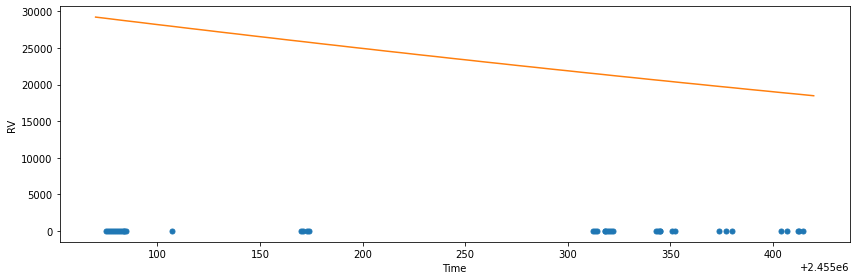

In [42]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print(post)

NameError: name 'ylabel' is not defined

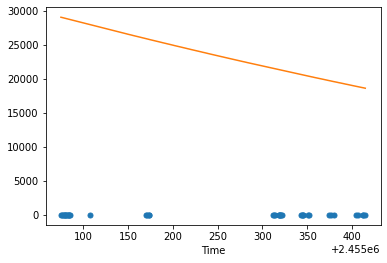

In [39]:
# Convenient function for plotting fits
plt.errorbar(
        like.x, like.model(like.x)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    
t_start = np.min(like.x)
t_stop = np.max(like.x)

ti = np.linspace(t_start,t_stop,10000)
plt.plot(ti, like.model(ti))
plt.xlabel('Time')
ylabel('RV')


In [22]:
print(like.params['per1'])

Parameter object: value = 0.83753, vary = True, mcmc scale = None
